Homework 3 Notebook

In [ ]:
#importing Stuff
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
#loading the genomics data_set from tfds
train_ds, test_ds = tfds.load('genomics_ood', split=['train','test'], as_supervised=True)

#genomics_ds, info = tfds.load('genomics_ood', split='train', with_info=True, as_supervised=True)
#print(info)

In [ ]:
#create a onehot vector by substiting and 
def onehotify(tensor):
    vocab = {'A': '1', 'C': '2', 'G': '3', 'T': '4'}
    for key in vocab.keys():
        tensor = tf.strings.regex_replace(tensor, key, vocab[key]) 
    split = tf.strings.bytes_split(tensor)
    labels = tf.cast(tf.strings.to_number(split), tf.uint8) 
    onehot = tf.one_hot(labels, 4)
    onehot = tf.reshape(onehot, (-1,))
    return onehot

In [ ]:
# clean dataset, so labels and vectors are depicted as One-Hot-Tensors
def clean_dataset(g):
    # use the pre-defined function to replace Strings by Int-values
    g = g.map(lambda seq, label: (onehotify(seq), label)) 
    # convert the labels to one_hot_tensor
    g = g.map(lambda seq, label: (seq, tf.one_hot(label, depth=10))) 
    # return cleaned data
    return g


In [ ]:
#custom layer

class CustomLayer(tf.keras.layers.Layer):
    # init func with customizable size and activation function, standard units=8, Activation = sigmoid
    def __init__(self, units=8, activation=tf.nn.sigmoid):
        super(CustomLayer, self).__init__()
        self.units = units
        self.activation = activation
        
    # build function to apply shape of input to layer when build, creating according weights and biases 
    def build(self, input_shape):
        self.w = self.add_weight(shape=(input_shape[-1], self.units),
                                initializer='random_normal',
                                trainable=True)

        self.b = self.add_weight(shape=(self.units,), 
                              initializer='random_normal',
                              trainable=True)
    # when called return neuron output/drive by multiplying input with weights + bias and applying the activation function
    def call(self, inputs):
        x = tf.matmul(inputs, self.w) + self.b
        x = self.activation(x)
        return x
    

In [ ]:
#custom model with custom layer
class CustomModel(tf.keras.Model):
    
    # init our model with 2 hidden layers of 256 Units and sigmoid activation and one output layer with softmax activation
    def __init__(self):
        super(CustomModel, self).__init__()
        self.layer1 = CustomLayer(256) # sigmoid is standard
        self.layer2 = CustomLayer(256)
        self.out = CustomLayer(10, tf.nn.softmax)
    
    # cast the call-function as tf.function to increase efficiency
    @tf.function
    # pass the input through the layers of the network and return the output
    def call(self, inputs):
        x = self.layer1(inputs)
        x = self.layer2(x)
        x = self.out(x)
        return x

In [ ]:
# compute the loss of an input for the model and optimize/tweak according the parameters
def train_step(model, input, target, loss_function, optimizer):
    # use tf.gradientTape to compute loss, then gradients and apply these to the model to modify the parameters
    with tf.GradientTape() as tape:
        prediction = model(input)
        loss = loss_function(target, prediction)
        gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss


# compute the differences between or model prediction and the label, -> Supervision
def test(model, test_data, loss_function):
  # test over complete test data
  test_accuracy_aggregator = []
  test_loss_aggregator = []

  for (input, target) in test_data:
    prediction = model(input)
    sample_test_loss = loss_function(target, prediction)
    sample_test_accuracy =  np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
    sample_test_accuracy = np.mean(sample_test_accuracy)
    test_loss_aggregator.append(sample_test_loss.numpy())
    test_accuracy_aggregator.append(np.mean(sample_test_accuracy))
    
# for all input and computed losses get the mean of accuracy and loss and return them
  test_loss = tf.reduce_mean(test_loss_aggregator)
  test_accuracy = tf.reduce_mean(test_accuracy_aggregator)

  return test_loss, test_accuracy

In [ ]:
# clear any leftover computations of the TF Background
tf.keras.backend.clear_session()

In [ ]:
#create clean Data-sets for Training and testing
test_ds = test_ds.apply(clean_dataset)
train_ds = train_ds.apply(clean_dataset)  

#take a smaller amount of samples for our purposes
test_ds = test_ds.take(1000)
train_ds = train_ds.take(100000)

#shuffle, batch and prefetch both Datasets
train_ds = train_ds.shuffle(1000)
train_ds = train_ds.batch(1000)
train_ds = train_ds.prefetch(20)

test_ds = test_ds.shuffle(1000)
test_ds = test_ds.batch(1000)
test_ds = test_ds.prefetch(20)

#predefine learning-rate and epochs
num_epochs = 10
alpha = 0.1

# create a model
model = CustomModel()

# define loss-function and optimizer
cross_entropy_loss = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.SGD(alpha)

# create empty arrays to store test/accuracy values, to track the network progress
train_losses = []
test_losses = []
test_accuracies = []

# get initial accuracy- and loss valus before training starts
test_loss, test_accuracy = test(model, test_ds, cross_entropy_loss)
test_losses.append(test_loss)
test_accuracies.append(test_accuracy)

train_loss, _ = test(model, train_ds, cross_entropy_loss)
train_losses.append(train_loss)


# training loop
for epoch in range(num_epochs):
    # print accuracy of each epoch
    print(f'Epoch: {str(epoch)} starting with accuracy {str(test_accuracies[-1])}')
    
    loss_epoch = []
    # for all input, do a forwardstep and obtain loss
    for input, target in train_ds:
        train_loss = train_step(model, input, target, cross_entropy_loss, optimizer)
        loss_epoch.append(train_loss)
    # get the mean loss of this epoch by using reduce_sum of TF over all input-losses and appending to the array  
    train_losses.append(tf.reduce_mean(loss_epoch))
    
    # get the losses and accuracy of this epoch and store them
    test_loss, test_accuracy = test(model, test_ds, cross_entropy_loss)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)
    
# print accuracy after 10 epochs
print(test_accuracies[-1])
          
    

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Assign: 2, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Assign: 2, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Assign: 2, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Assign: 2, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Assign: 2, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Assign: 2, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Assign: 2, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Assign: 2, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Assign: 2, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Assign: 2, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Assign: 2, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Assign: 2, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2021-11-14 16:58:16.453210: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-11-14 16:58:16.454004: W tensorflow/core/platform/profile_utils/cpu_utils.cc:126] Failed to get CPU frequency: 0 Hz


Epoch: 0 starting with accuracy tf.Tensor(0.096, shape=(), dtype=float64)


2021-11-14 16:58:33.801601: W tensorflow/core/framework/op_kernel.cc:1775] OP_REQUIRES failed at mlc_matmul_ops.cc:136 : Internal: TransposeMLCBytes: Input bytes is nullptr.
2021-11-14 16:58:33.803105: W tensorflow/core/framework/op_kernel.cc:1775] OP_REQUIRES failed at mlc_matmul_ops.cc:207 : Aborted: Compute: Operation received an exception: Compute: No MLCTrainingGraph has been found.


InternalError:  TransposeMLCBytes: Input bytes is nullptr.
	 [[node gradients/custom_layer_2/MatMul_grad/MLCMatMul_1 (defined at Users/noomin/miniforge3/envs/tf_m1/lib/python3.8/site-packages/tensorflow/compiler/tf2mlcompute/ops/gen_mlc_ops.py:5535) ]] [Op:__inference___backward_call_3593_3629]

Errors may have originated from an input operation.
Input Source operations connected to node gradients/custom_layer_2/MatMul_grad/MLCMatMul_1:
 gradients/custom_layer_2/add_grad/MLCAddGrad (defined at Users/noomin/miniforge3/envs/tf_m1/lib/python3.8/site-packages/tensorflow/compiler/tf2mlcompute/ops/gen_mlc_ops.py:304)

Function call stack:
__backward_call_3593


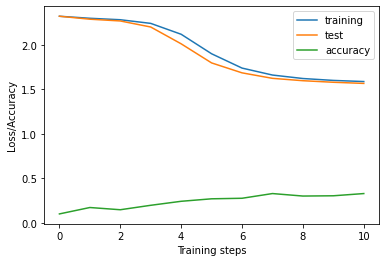

In [ ]:
# plot the values stored over training and test time with pyplot
import matplotlib.pyplot as plt

plt.figure()
line1, = plt.plot(train_losses)
line2, = plt.plot(test_losses)
line3, = plt.plot(test_accuracies)
plt.xlabel("Training steps")
plt.ylabel("Loss/Accuracy")
plt.legend((line1,line2,line3),("training","test", "accuracy"))
plt.show()